## Когоротный анализ с помощью  Python

### Импортируем библиотеки

In [32]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm #для создания цветных карт
from ipywidgets import interact #добавим интрактивности для чартов
import csv
from datetime import datetime


#настройки для визуализаций
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("Greens", 8, .75)
seq_col_brew = sns.light_palette("seagreen", as_cmap=True)

### Подгружаем данные

In [3]:
starting_df = pd.read_csv('./Coding/CSV_Datasets/For BI/installs by devices.csv', index_col=0)
starting_df[['feature1', 'feature2', 'feature3']] = starting_df[['feature1', 'feature2', 'feature3']].astype(int)
starting_df = starting_df.rename(columns={'date':'date_session'})
starting_df.head()

,device_uuid,date_session,feature1,feature2,feature3,platform,user_registered,country
0,d2e328be-5adb-4a43-ba2e-3d03231e7fb3,2016-03-01,5,4,3,iOS,False,NL
1,d2e328be-5adb-4a43-ba2e-3d03231e7fb3,2016-04-01,4,3,2,iOS,False,NL
2,d2e328be-5adb-4a43-ba2e-3d03231e7fb3,2016-05-01,2,1,1,iOS,False,NL
3,c63bc11f-4ee2-4cd2-8088-84a5cdbc57f4,2016-10-01,4,3,2,iOS,False,FR
4,c63bc11f-4ee2-4cd2-8088-84a5cdbc57f4,2016-11-01,9,7,5,iOS,False,FR


### На основе наших данных создадим Series с наборы значений для 3-х сегментов

In [4]:
# Для сегментации по странам
country_values = ['All countries'] + list(starting_df['country'].unique())

# Для сегментации по типу устройства
platform_values = ['All platforms'] + list(starting_df['platform'].unique())

# Для статуса регистрации (Yes/No)
user_registered_values = ['True and False'] + list(starting_df['user_registered'].unique())


### Переходим к самой сегментации

In [5]:
# Применяем фильтры к датафрейму
def segmentation(df, country, platform, user_registered):
    if country != 'All countries':
        df = df[df['country'] == country]
    if platform != 'All platforms':
        df = df[df['platform'] == platform]
    if user_registered != 'True and False':
        df = df[df['user_registered'] == user_registered]
    return df

In [10]:
#Пример того, что будем получать на выходе
country_value = 'NL'
platform_value = 'Android'
user_registered_value = False
df2 = segmentation(starting_df.copy(), country=country_value, platform=platform_value, user_registered=user_registered_value)
df2.head(10)

,device_uuid,date_session,feature1,feature2,feature3,platform,user_registered,country
25,e1a17625-01de-498f-b33d-834593a0e122,2016-02-01,10,8,6,Android,False,NL
89,745913b1-9122-4836-8bb7-f7c026ae63ad,2016-05-01,11,8,6,Android,False,NL
97,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-07-01,4,3,2,Android,False,NL
98,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-08-01,9,7,5,Android,False,NL
99,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-09-01,7,5,4,Android,False,NL
100,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-10-01,8,6,4,Android,False,NL
101,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-11-01,12,9,7,Android,False,NL
102,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-12-01,12,9,7,Android,False,NL
104,0de63b70-6833-47b6-bd91-b875a46c0a9a,2016-04-01,7,5,4,Android,False,NL
115,f42ecbf8-dd89-4577-82b3-628169970859,2016-02-01,1,0,0,Android,False,NL


### Строим когороты по нашим сегментам

In [13]:
# Step 1 - Готовим когортны и когортные группы
def preprocess_cohorting(df2):
    df2['sum'] = df2['feature1'] + df2['feature2'] + df2['feature3']# колонка с суммой всех фичей
    df2['date_session'] = pd.to_datetime(df2['date_session']) #задаем форматы даты
    
   
    df2['period_session'] = df2['date_session'].apply(lambda x: x.strftime('%Y-%m'))#создаем когорту по времени сессии
    # определим когортную группу по времени первой сессии
    df2.set_index('device_uuid', inplace=True)
    df2['cohort_group'] = df2.groupby(level=0)['date_session'].min().apply(lambda x:  x.strftime('%Y-%m'))
    df2.reset_index(inplace=True)
    
    return df2

Смотрим, как это будет выглядеть

In [14]:
df = preprocess_cohorting(df2)
df.head()

,device_uuid,date_session,feature1,feature2,feature3,platform,user_registered,country,sum,period_session,cohort_group
0,e1a17625-01de-498f-b33d-834593a0e122,2016-02-01,10,8,6,Android,False,NL,24,2016-02,2016-02
1,745913b1-9122-4836-8bb7-f7c026ae63ad,2016-05-01,11,8,6,Android,False,NL,25,2016-05,2016-05
2,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-07-01,4,3,2,Android,False,NL,9,2016-07,2016-07
3,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-08-01,9,7,5,Android,False,NL,21,2016-08,2016-07
4,cff6f248-4b13-4861-ae71-6cf435b888b3,2016-09-01,7,5,4,Android,False,NL,16,2016-09,2016-07


Группируем девайсы по когортам

In [15]:
# Step 2 - Формируем Pivot table c количеством юзеров по когортам/группам
def build_cohort_data(df):
    
    # сначала задаем разрезы группировки
    grouped = df.groupby(['cohort_group', 'period_session'])
    
    # а затем задаем ка будем аггригировать - считаем кол-во юезров по (device_uuid) в группе и сумму фичей
    cohorts = grouped.agg({'device_uuid': pd.Series.nunique,
                      'sum': np.sum})

    # дадим новые названия столбцам
    cohorts.rename(columns={'device_uuid': 'all_users',
                       'sum': 'all_num_events'}, inplace=True) # all_num_events - это сумма всех фичей
    return cohorts

Смотрим, как это будет выглядеть

In [16]:
build_cohort_data(df)

all_users  all_num_events
cohort_group period_session                           
2016-02      2016-02                 9             126
             2016-03                 4              26
             2016-04                 4              86
             2016-05                 3              81
             2016-06                 3              50
...                                ...             ...
2016-10      2017-04                 9             154
             2017-05                 8             158
             2017-06                 8              81
             2017-07                 7              77
             2017-08                 7             118

[135 rows x 2 columns]

Создадим функцию со счетчиком строк сегментированного датафрейма

In [17]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df))+0   #+0 - это чтобы массив всегда начинался с нуля
    return df

А теперь применим эту функцию для расчета кол-ва строк в разрезе когортных групп

In [18]:
# Step 3 - применяем счетчик кол-ва периодов в рамках одной когортной группы
cohorts = build_cohort_data(df).groupby(level=0).apply(cohort_period)
cohorts.head(5)

all_users  all_num_events  cohort_period
cohort_group period_session                                          
2016-02      2016-02                 9             126              0
             2016-03                 4              26              1
             2016-04                 4              86              2
             2016-05                 3              81              3
             2016-06                 3              50              4

Промежуточные шаги для расчета когортной матрицы:
    1. Делаем составной индекс
    2. Формируем Series со кол-вом юзеров, пришедших в первый период (то, с чем потом будем сравнивать последующие визиты)

In [23]:
# Step 4 - промежуточный расчеты
def cohort_reindex_and_group_size(df):
    # reindex the dataframe
    df.reset_index(inplace=True)
    df.set_index(['cohort_group', 'cohort_period'], inplace=True) #назначаем двойной индекс
    cohort_group_size = df['all_users'].groupby(level=0).first() # форимруем Series
    return df, cohort_group_size # функция выдает 2 результата

In [24]:
# Смотрим на первый результат
cohorts, cohort_group_size = cohort_reindex_and_group_size(cohorts)
cohorts.head(5)

period_session  all_users  all_num_events
cohort_group cohort_period                                          
2016-02      0                    2016-02          9             126
             1                    2016-03          4              26
             2                    2016-04          4              86
             3                    2016-05          3              81
             4                    2016-06          3              50

In [25]:
# Смотрим на второй результат
cohort_group_size

cohort_group
2016-02     9
2016-03     8
2016-04    18
2016-05    14
2016-06    13
2016-07    16
2016-08     6
2016-09    13
2016-10    15
Name: all_users, dtype: int64

### Строим когортную матрицу

In [26]:
# Step 5
def calculate_user_retention(df,cohort_group_size):
    df = df['all_users'].unstack(0).divide(cohort_group_size, axis=1)
    return df

In [27]:
# Смотрим что на выходе
user_retention = calculate_user_retention(cohorts, cohort_group_size)
user_retention.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
1,0.444444,0.500,0.555556,0.428571,0.461538,0.6875,0.333333,0.538462,0.733333
2,0.444444,0.500,0.500000,0.428571,0.307692,0.6875,0.333333,0.461538,0.733333
3,0.333333,0.500,0.500000,0.357143,0.307692,0.6250,0.333333,0.384615,0.733333
4,0.333333,0.375,0.388889,0.357143,0.307692,0.6250,0.333333,0.307692,0.666667


### А теперь объеденим все шаги в одну связку

In [28]:
def build_cohorts(df): #Вызывает по порядку все выше созданые функции
    
    # step 1
    df = preprocess_cohorting(df)
    
    # step 2
    cohorts = build_cohort_data(df)
    
    # step 3
    cohorts_s1 = cohorts.groupby(level=0).apply(cohort_period)
    
    # step 4
    cohorts_s2, cohort_group_size = cohort_reindex_and_group_size(cohorts_s1)
    
    # step 5
    user_retention = calculate_user_retention(cohorts_s2, cohort_group_size)

    
    return user_retention

In [29]:
# Запускаем!
build_cohorts(df)

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
1,0.444444,0.500,0.555556,0.428571,0.461538,0.6875,0.333333,0.538462,0.733333
2,0.444444,0.500,0.500000,0.428571,0.307692,0.6875,0.333333,0.461538,0.733333
3,0.333333,0.500,0.500000,0.357143,0.307692,0.6250,0.333333,0.384615,0.733333
4,0.333333,0.375,0.388889,0.357143,0.307692,0.6250,0.333333,0.307692,0.666667
5,0.333333,0.375,0.333333,0.357143,0.230769,0.6250,0.333333,0.307692,0.666667
6,0.333333,0.375,0.333333,0.357143,0.230769,0.5625,0.333333,0.307692,0.600000
7,0.333333,0.375,0.333333,0.357143,0.230769,0.5625,0.333333,0.230769,0.533333
8,0.222222,0.375,0.277778,0.357143,0.153846,0.5625,0.333333,0.230769,0.533333


### Делаем визуализацию

Строим линейный график ретеншена. Каждая линия соотв. отдельной когорте.
Чем выше уровень линии над осью Х - тем выше вероятность возврата юзера,
и наоборот, чем сильнее кривая падает вниз, тем сильнее churn

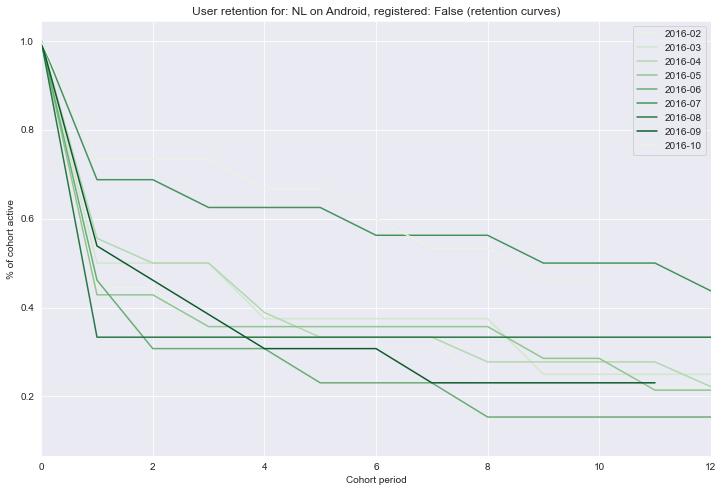

In [33]:
title = 'User retention for: ' + country_value + ' on ' + platform_value +', registered: ' + str(user_registered_value) 

fig, ax = plt.subplots(figsize=(12,8))
location = ['upper right']

for i in range(0, len(user_retention.columns)):
    plt.plot(user_retention[user_retention.columns[i]], label = user_retention.columns[i])

plt.title(title + ' (retention curves)')
plt.xlabel("Cohort period")
plt.ylabel("% of cohort active")
ax.legend(loc = location[0])
plt.xlim(0, 12)
plt.show()

Строим хтимэп на основе когортной матрицы

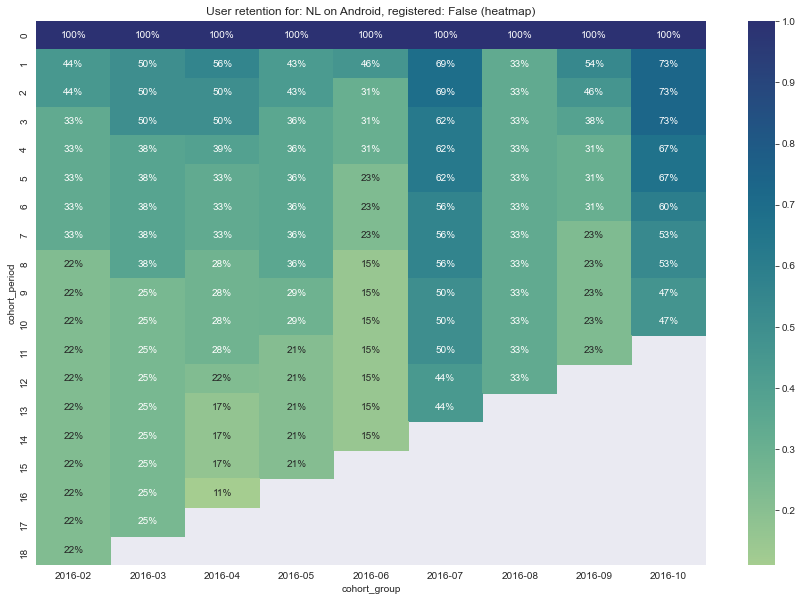

In [34]:
# Чем гуще цвет - тем выше ретеншн
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(user_retention, cmap="crest", ax=ax, annot=True, fmt='.0%')
ax.set_title(title + ' (heatmap)')
plt.show()

### Добавляем интерактив в наши графики!

In [36]:
# Функция для вывода графиков в интерактивный режим
def func_cohort_analysis(country, platform, user_registered):
    
    # Задаем сегментацию
    segmented_user_events_df = segmentation(starting_df.copy(),
                               country=country, platform=platform, user_registered=user_registered)
    
    # Запускаем связку расчетов
    user_retention = build_cohorts(segmented_user_events_df)
    
    

    # Строим линейный график
    
    title = 'User retention for: ' + country + ' on ' + platform +', registered: ' + str(user_registered) 

    fig, ax = plt.subplots(figsize=(12,8))
    location = ['upper right']

    seq_col_brew = sns.light_palette("seagreen", as_cmap=True)

    for i in range(0, len(user_retention.columns)):
        plt.plot(user_retention[user_retention.columns[i]], label = user_retention.columns[i])

    plt.title(title + ' (retention curves)')
    plt.xlabel("Cohort period")
    plt.ylabel("% of cohort active")
    ax.legend(loc = location[0])
    plt.xlim(0, 12)
    plt.show()

    # Строим хитмэп
    
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(user_retention, cmap="crest", ax=ax, annot=True, fmt='.0%')
    ax.set_title(title + ' (heatmap)')
    plt.show()

In [37]:
# ЗАПУСКАЕМ!
interact(func_cohort_analysis, country=country_values , platform=platform_values, user_registered=user_registered_values);

interactive(children=(Dropdown(description='country', options=('All countries', 'NL', 'FR', 'AU'), value='All …